<a href="https://colab.research.google.com/github/Ovrup/EVA-Assignment-5/blob/master/EVA_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://keras.io/
!pip install -q keras
import keras

In [0]:
# Importing all necessary modules in Keras
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

In [120]:

# example of standardizing a image dataset
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
# load dataset
(trainX, trainY), (testX, test_Y) = mnist.load_data()
print(f'training set = {trainX.shape}')
print(f'test set = {testX.shape}')

# reshape dataset to have a single channel
# The train & test set are 3D matrix.The training set is of shape (60000,28,28) & test set is (10000,28,28). But here the CNN model expects
# the input shape to be 4D i.e (no of samples,height,width,channel).Channel implies whether the image is gray scale or colour(RGB). In case of
# RGB image the 4th dimension would be 3. In this case the images are gray scale. Hence, it is 1. That's why training & test set are reshaped into
# matrices of shape (60000,28,28,1) & (10000,28,28,1) respectively.
width, height, channels = trainX.shape[1], trainX.shape[2], 1
trainX = trainX.reshape((trainX.shape[0], width, height, channels))
testX = testX.reshape((testX.shape[0], width, height, channels))
print(f'Reshaped training set = {trainX.shape}')
print(f'Reshaped test set = {testX.shape}')

# report pixel max, min, means and standard deviations
print('training maximum pixel = %.3f , minimum pixel = %.3f' %(trainX.max(), trainX.min()))
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainY, batch_size=64)

# get a batch
batchX, batchy = iterator.next()


# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std(), batchX.max(), batchX.min())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainY, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

training set = (60000, 28, 28)
test set = (10000, 28, 28)
Reshaped training set = (60000, 28, 28, 1)
Reshaped test set = (10000, 28, 28, 1)
training maximum pixel = 255.000 , minimum pixel = 0.000
Statistics train=33.318 (78.567), test=33.791 (79.172)
Data Generator mean=33.318, std=78.567
(64, 28, 28, 1) 0.038626786 1.0434185 2.8215446 -0.42407447
(60000, 28, 28, 1) -3.4560264e-07 0.9999998


In [121]:
# 1st 10 labels for training set. As printed below the 1st element is 5 which implies the 1st image of training set is of digit 5 and so on. 
trainY[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
# As shown above the label matrix(Y_train & Y_test) holds values that implies what digit the image is about. So, keras may find some relational order
# between these values. To avoid this problem we hot encode the matrix into a binary matrix. This matrix has number of columns equal to the number
# of classes(10 columns in this scenario). Each row defines the label of one sample point in data set & has only one '1' & others are '0'. '1' at
# particular index position implies the digit equal to the column number. For example, the 1st row(1st sample of training data set) has '1' at column
# number 5(starting from 0) which means this is image of digit 5.
# Convert 1-dimensional class arrays to 10-dimensional class matrices 
trainY = np_utils.to_categorical(trainY, 10)
testY = np_utils.to_categorical(test_Y, 10)

In [123]:
# Label matrix hot encoded into binary matrix
trainY[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
from keras.layers import Activation

model = Sequential()

# Input = 28*28*1
model.add(Convolution2D(10, kernel_size = (3,3), input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

# Input = 26*26*10
model.add(Convolution2D(16, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Input = 24*24*16
model.add(Convolution2D(16, kernel_size = (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

# Input = 22*22*16
model.add(Convolution2D(10, kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Input = 22*22*10
model.add(MaxPooling2D(pool_size = (2,2)))

# Input = 11*11*10
model.add(Convolution2D(16, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Input = 9*9*16
model.add(Convolution2D(16, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

# Input = 7*7*16
model.add(Convolution2D(10, kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.15))

# Input = 7*7*10
model.add(Convolution2D(10, 7))

# Input = 1*1*10
model.add(Flatten())
model.add(Activation('softmax'))

In [125]:
# summary() function displays the model structure i.e for each layer how many parameters used, what is the shape of output image
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 26, 26, 10)        100       
_________________________________________________________________
batch_normalization_29 (Batc (None, 26, 26, 10)        40        
_________________________________________________________________
activation_33 (Activation)   (None, 26, 26, 10)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 26, 26, 10)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 16)        1456      
_________________________________________________________________
batch_normalization_30 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
activation_34 (Activation)   (None, 24, 24, 16)        0         
__________

In [0]:

from keras.optimizers import SGD

In [0]:
# Compile the model with SGD optimizer. Since this is multi class problem (10 classes) 'categorical_crossentropy' is used as loss function.
# accuracy is used as metrics which means while training this accuracy metrics will be monitored.
model.compile(loss='categorical_crossentropy',
             optimizer=SGD(lr=0.1,decay = 0.00001, momentum = 0.8),
             metrics=['accuracy'])

In [0]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [133]:
# Creates batches of training data yielded from generator
train_iterator = datagen.flow(trainX, trainY,batch_size = 64)
print(len(train_iterator))

# Creates batches of test data yielded from generator
test_iterator = datagen.flow(testX, testY,batch_size = 64)
print(len(test_iterator))

938
157


In [134]:
# Train the model with fit() which takes the training data set along with the label matrix. Epoch means one round of the whole data set. Batch size
# determines in an epoch how many images to be processed parallelly. Batch size 32 means in an epoch in one iteration 32 images are processed.
model.fit_generator(train_iterator, steps_per_epoch =len(train_iterator) , epochs=40, callbacks = callbacks_list,validation_data = test_iterator, validation_steps = len(test_iterator) , verbose = 1)

Epoch 1/40
938/938 [==============================] - 13s 14ms/step - loss: 0.0701 - acc: 0.9787 - val_loss: 0.0386 - val_acc: 0.9875

Epoch 00001: val_acc improved from -inf to 0.98750, saving model to weights.best.hdf5
Epoch 2/40
938/938 [==============================] - 11s 12ms/step - loss: 0.0434 - acc: 0.9862 - val_loss: 0.0383 - val_acc: 0.9885

Epoch 00002: val_acc improved from 0.98750 to 0.98850, saving model to weights.best.hdf5
Epoch 3/40
938/938 [==============================] - 11s 12ms/step - loss: 0.0384 - acc: 0.9878 - val_loss: 0.0334 - val_acc: 0.9883

Epoch 00003: val_acc did not improve from 0.98850
Epoch 4/40
938/938 [==============================] - 11s 11ms/step - loss: 0.0356 - acc: 0.9887 - val_loss: 0.0352 - val_acc: 0.9888

Epoch 00004: val_acc improved from 0.98850 to 0.98880, saving model to weights.best.hdf5
Epoch 5/40
938/938 [==============================] - 11s 11ms/step - loss: 0.0329 - acc: 0.9893 - val_loss: 0.0252 - val_acc: 0.9915

Epoch 00005

In [0]:
# load weights
model.load_weights("weights.best.hdf5")

In [0]:
# Compile the model with SGD optimizer. Since this is multi class problem (10 classes) 'categorical_crossentropy' is used as loss function.
# accuracy is used as metrics which means while training this accuracy metrics will be monitored.
model.compile(loss='categorical_crossentropy',
             optimizer=SGD(lr=0.01,decay = 0.00001, momentum = 0.8),
             metrics=['accuracy'])

In [137]:
# Now the model is trained which means the weights are optimized. model.evaluate() predicts the classes of each image in test set & then calculate
# test set loss & accuracy.
score = model.evaluate_generator(test_iterator, steps = len(test_iterator), verbose=1)

157/157 [==============================] - 2s 13ms/step


In [138]:
# score is a vector that holds the test set loss & accuracy
print(score)

[0.016879419930209406, 0.995]


In [0]:
# Predict the class of each image in test set & stores in y_pred matrix
y_pred = model.predict_classes(testX)

In [0]:
# Reshaped the test set to (10000, 28, 28) to be able to display images
testX = testX.reshape(testX.shape[0], width, height)

In [141]:
# Shape of test set
print(testX.shape)

(10000, 28, 28)


In [0]:
# Storing the indexes of miss classified images in a list
miss_classified = [idx for idx, i in enumerate(y_pred) if i != test_Y[idx]]

In [0]:
# All miss classified images are taken from test set & stored in a new numpy array
miss_classified_images = np.array([testX[i] for i in miss_classified])

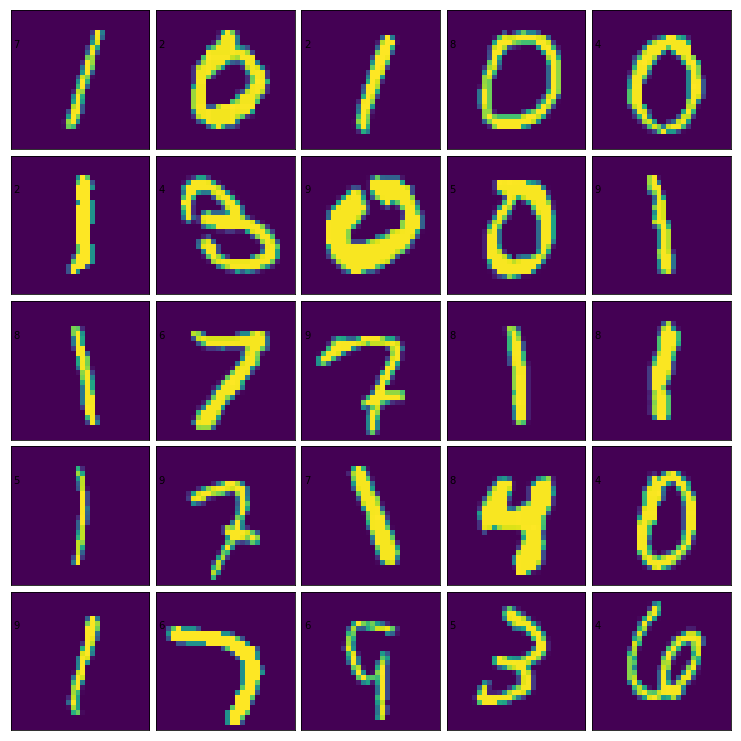

In [145]:
# Displaying 25 miss classified images
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(miss_classified_images[i])
    # label the image with the target value
    ax.text(0, 7, str(y_pred[i]))